In [1]:
!pip install transformers
!pip install timm

In [44]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
from google.colab import drive
from pathlib import Path

In [3]:
drive.mount('/content/drive')
path = Path('/content/drive/MyDrive/Colab_Data/Person_Tracking')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
images = [str(path) for path in path.glob('*.jpg')]
images

['/content/drive/MyDrive/Colab_Data/Person_Tracking/IMG_20230210_225957.jpg']

In [5]:
image = Image.open(images[0])

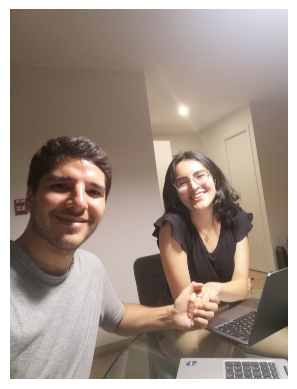

In [6]:
fig, ax = plt.subplots()
ax.imshow(image)
ax.set_axis_off()
plt.show()

In [12]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
inputs = processor(images=image, return_tensors="pt")


(4896, 6528)

In [14]:
outputs = model(**inputs)

In [33]:
# Returns the original image size: [width, height]
target_sizes = torch.tensor([[image.size[1], image.size[0]]])
target_sizes

tensor([[6528, 4896]])

In [39]:
results = processor.post_process_object_detection(outputs, target_sizes = target_sizes, threshold=0.9)
results

[{'scores': tensor([0.9768, 0.9102, 0.9967, 0.9991, 0.9979], grad_fn=<IndexBackward0>),
  'labels': tensor([62, 76, 73,  1,  1]),
  'boxes': tensor([[2159.4521, 4289.0542, 2859.1797, 5287.0815],
          [3592.7871, 5290.3394, 4417.7974, 5881.4331],
          [3396.8975, 4527.0781, 4892.2583, 6015.0342],
          [  10.6617, 2217.8462, 3720.9016, 6443.0029],
          [2489.4548, 2481.7307, 4295.2261, 5243.8354]],
         grad_fn=<IndexBackward0>)}]

In [42]:
for result in results:
  for score, label, box in zip(result["scores"], result["labels"], result["boxes"]):
      box = [round(i, 2) for i in box.tolist()]
      print(
              f"Detected {model.config.id2label[label.item()]} with confidence "
              f"{round(score.item(), 3)} at location {box}"
      )

Detected chair with confidence 0.977 at location [2159.45, 4289.05, 2859.18, 5287.08]
Detected keyboard with confidence 0.91 at location [3592.79, 5290.34, 4417.8, 5881.43]
Detected laptop with confidence 0.997 at location [3396.9, 4527.08, 4892.26, 6015.03]
Detected person with confidence 0.999 at location [10.66, 2217.85, 3720.9, 6443.0]
Detected person with confidence 0.998 at location [2489.45, 2481.73, 4295.23, 5243.84]


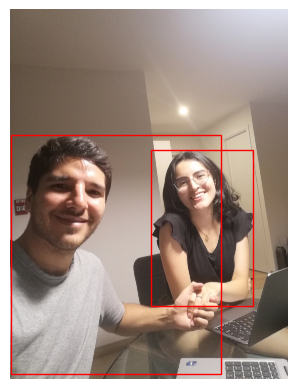

In [56]:
fig, ax = plt.subplots()
ax.imshow(image)
ax.set_axis_off()
for result in results:
  for score, label, box in zip(result["scores"], result["labels"], result["boxes"]):
    if model.config.id2label[label.item()] == 'person':
      box = box.tolist()
      box_image = Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')
      ax.add_patch(box_image)
plt.show()